In [1]:
import json
import os
import numpy as np
import tensorflow as tf
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from tensorflow.keras.layers import Input,Dense, Embedding, LSTM,Flatten,Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision
from collections import Counter
plt.rcParams['figure.figsize']=20,10

In [2]:
##Inicjalizacja akceleratora GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
#Korzystanie z połowicznej precyzji, która przyśpiesza proces trenowania sieci zachowując tą samą skuteczność co przy 
#pojedynczej precyzji
policy=mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070, compute capability 8.6


In [3]:
#Wczytanie zbioru danych pliku json
df=pd.read_json('C:/Users/komej/Downloads/News_Category.json',lines=True)

In [4]:
df.head(15)

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,Ron Dicker,https://www.huffingtonpost.com/entry/morgan-fr...,"""It is not right to equate horrific incidents ...",2018-05-26
6,ENTERTAINMENT,Donald Trump Is Lovin' New McDonald's Jingle I...,Ron Dicker,https://www.huffingtonpost.com/entry/donald-tr...,"It's catchy, all right.",2018-05-26
7,ENTERTAINMENT,What To Watch On Amazon Prime That’s New This ...,Todd Van Luling,https://www.huffingtonpost.com/entry/amazon-pr...,There's a great mini-series joining this week.,2018-05-26
8,ENTERTAINMENT,Mike Myers Reveals He'd 'Like To' Do A Fourth ...,Andy McDonald,https://www.huffingtonpost.com/entry/mike-myer...,"Myer's kids may be pushing for a new ""Powers"" ...",2018-05-26
9,ENTERTAINMENT,What To Watch On Hulu That’s New This Week,Todd Van Luling,https://www.huffingtonpost.com/entry/hulu-what...,You're getting a recent Academy Award-winning ...,2018-05-26


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]),
 <a list of 41 Text major ticklabel objects>)

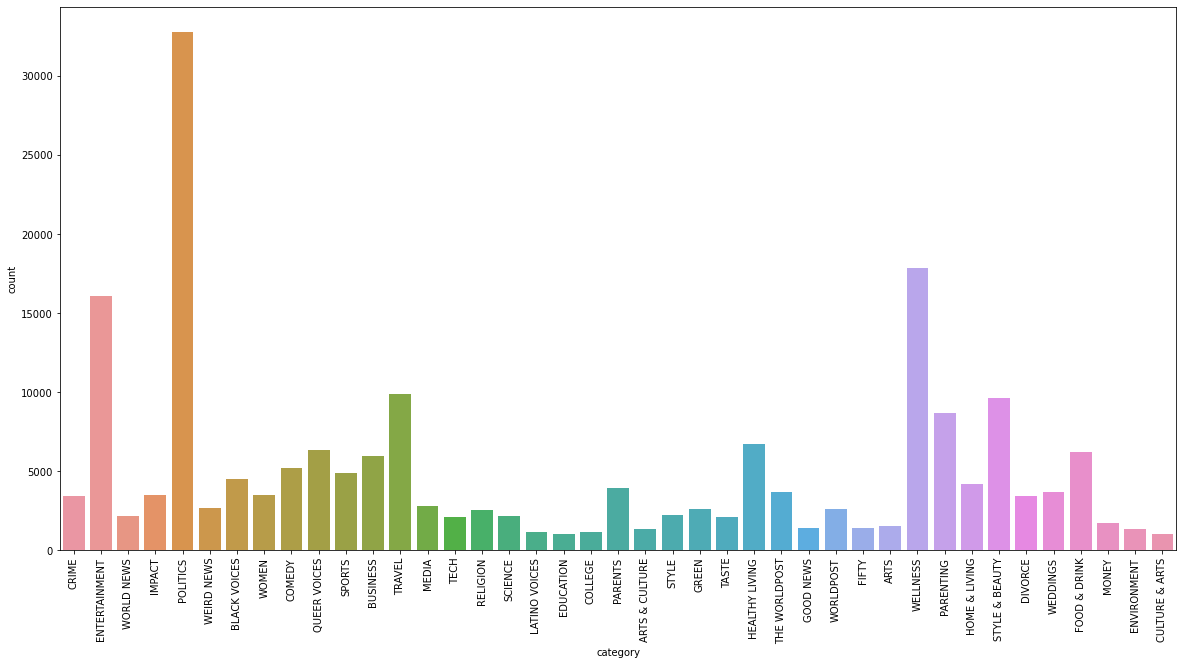

In [5]:
sns.countplot(x=df['category'])
plt.xticks(rotation=90)

In [6]:
#Tworzenie unikalnej liczby dla każdej kategorii
mapping=dict(enumerate(df['category'].unique()))
label_map={value:key for key,value in mapping.items()}

In [7]:
label_map

{'CRIME': 0,
 'ENTERTAINMENT': 1,
 'WORLD NEWS': 2,
 'IMPACT': 3,
 'POLITICS': 4,
 'WEIRD NEWS': 5,
 'BLACK VOICES': 6,
 'WOMEN': 7,
 'COMEDY': 8,
 'QUEER VOICES': 9,
 'SPORTS': 10,
 'BUSINESS': 11,
 'TRAVEL': 12,
 'MEDIA': 13,
 'TECH': 14,
 'RELIGION': 15,
 'SCIENCE': 16,
 'LATINO VOICES': 17,
 'EDUCATION': 18,
 'COLLEGE': 19,
 'PARENTS': 20,
 'ARTS & CULTURE': 21,
 'STYLE': 22,
 'GREEN': 23,
 'TASTE': 24,
 'HEALTHY LIVING': 25,
 'THE WORLDPOST': 26,
 'GOOD NEWS': 27,
 'WORLDPOST': 28,
 'FIFTY': 29,
 'ARTS': 30,
 'WELLNESS': 31,
 'PARENTING': 32,
 'HOME & LIVING': 33,
 'STYLE & BEAUTY': 34,
 'DIVORCE': 35,
 'WEDDINGS': 36,
 'FOOD & DRINK': 37,
 'MONEY': 38,
 'ENVIRONMENT': 39,
 'CULTURE & ARTS': 40}

In [8]:
df['category']=df['category'].replace(label_map)

In [9]:
#Funkcja dzięki której z tekstu usuwana jest interpunkcja
def remove_punct(text):
    transaltor=str.maketrans("","",string.punctuation)
    return text.translate(transaltor)
def lowercase(inp):
    return inp.lower()

In [10]:
#Funkcja która liczy wszystkie słowa
def counter_words(text):
    count=Counter()
    for txt in text.values:
        for word in txt.split():
            count[word] +=1
    return count
counter=counter_words(df.headline)

In [11]:
num_unique_words=len(counter)

In [12]:
num_unique_words

119488

In [13]:
df['headline']=df.headline.map(remove_punct)
df['headline']=df.headline.map(lowercase)

In [14]:
#Dzielenie zbioru danych na część przeznaczoną do trenowania sieci i część do jej późniejszego oceniania 
train_size=int(df.shape[0]*0.9)

train_df=df[:train_size]
val_df=df[train_size:]

train_sentences=train_df.headline.to_numpy()
train_labels=train_df.category.to_numpy()
val_sentences=val_df.headline.to_numpy()
val_labels=val_df.category.to_numpy()

In [15]:
#W tym miejscu jest tworzony indeks słownictwa, gdzie każdy wyraz ma przypisaną unikalną liczbe
tokenizer=Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences)
word_index=tokenizer.word_index

In [16]:
#Zamienia tekst na sekwencję liczb
train_sequences=tokenizer.texts_to_sequences(train_sentences)
val_sequences=tokenizer.texts_to_sequences(val_sentences)


In [17]:
#Zapewnia wszystkim sekwencjom jednakową długość
train_padd=pad_sequences(train_sequences,padding='post',truncating='post',maxlen=35)
val_padd=pad_sequences(val_sequences,padding='post',truncating='post',maxlen=35)

In [18]:
num_cls=len(label_map)

In [19]:
inp=Input(shape=(train_padd[1].shape))
x1=Embedding(num_unique_words,64)(inp)
x2=Bidirectional(LSTM(64,return_sequences=True))(x1)
x3=Bidirectional(LSTM(64,return_sequences=True))(x2)
x4=Flatten()(x3)
d1=Dense(96,activation='relu')(x4)
dr=Dropout(0.2)(d1)
d2=Dense(64,activation='relu')(dr)
dr2=Dropout(0.2)(d2)
out=Dense(num_cls,activation='softmax')(dr2)

In [20]:
model=Model(inp,out,name='NLP3')

In [21]:
model.summary()

Model: "NLP3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 35)]              0         
                                                                 
 embedding (Embedding)       (None, 35, 64)            7647232   
                                                                 
 bidirectional (Bidirectiona  (None, 35, 128)          66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 35, 128)          98816     
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 4480)              0         
                                                                 
 dense (Dense)               (None, 96)                430176 

In [22]:
#Monitorowanie spadku funkcji aby uzyskać jak najlepsze wyniki
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=4,verbose=1,mode='auto',restore_best_weights=True)

In [25]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(learning_rate=1e-4),metrics=['accuracy'])

In [26]:
history=model.fit(train_padd,train_labels,epochs=20,validation_split=0.1,callbacks=[monitor])

Epoch 1/20
5085/5085 [==============================] - 76s 14ms/step - loss: 2.8992 - accuracy: 0.2635 - val_loss: 2.7148 - val_accuracy: 0.3310
Epoch 2/20
5085/5085 [==============================] - 71s 14ms/step - loss: 2.4136 - accuracy: 0.3583 - val_loss: 2.3889 - val_accuracy: 0.4207
Epoch 3/20
5085/5085 [==============================] - 72s 14ms/step - loss: 2.1142 - accuracy: 0.4281 - val_loss: 2.1773 - val_accuracy: 0.4632
Epoch 4/20
5085/5085 [==============================] - 72s 14ms/step - loss: 1.9073 - accuracy: 0.4799 - val_loss: 2.1083 - val_accuracy: 0.5015
Epoch 5/20
5085/5085 [==============================] - 72s 14ms/step - loss: 1.7653 - accuracy: 0.5126 - val_loss: 2.0283 - val_accuracy: 0.5206
Epoch 6/20
5085/5085 [==============================] - 73s 14ms/step - loss: 1.6551 - accuracy: 0.5394 - val_loss: 2.0769 - val_accuracy: 0.5046
Epoch 7/20
5085/5085 [==============================] - 71s 14ms/step - loss: 1.5533 - accuracy: 0.5680 - val_loss: 2.1735 -

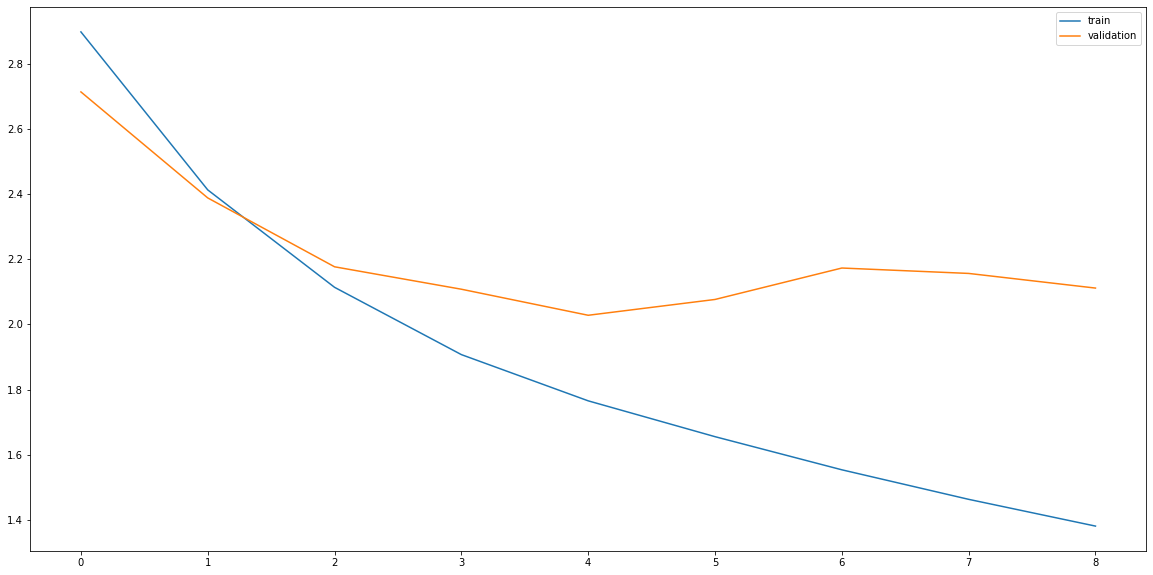

In [27]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()

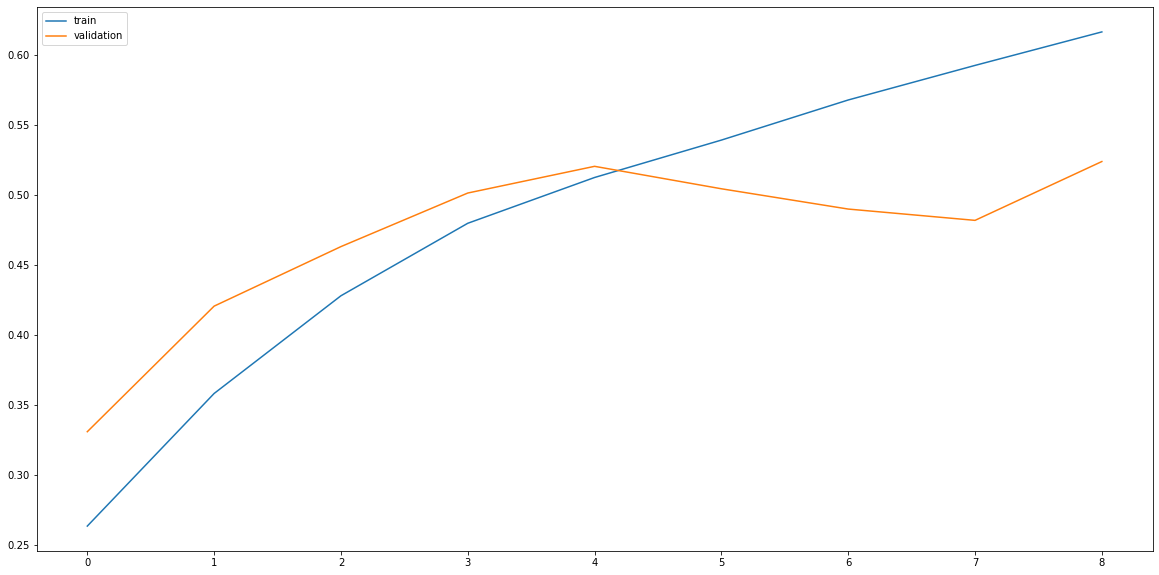

In [28]:
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='validation')
plt.legend()

In [29]:
#Dokładność sieci na zbiorze testowym
test_model=model.evaluate(val_padd,val_labels,verbose=1)
print(f'Dokładność: {round(test_model[1]*100,2)}%')

628/628 [==============================] - 4s 6ms/step - loss: 2.1695 - accuracy: 0.5046
Dokładność: 50.46%


In [30]:
score_eval=model.predict(val_padd)

In [31]:
print(metrics.classification_report(np.argmax(score_eval,1),val_labels,zero_division=1))

              precision    recall  f1-score   support

           0       0.25      0.23      0.24       128
           1       0.64      0.17      0.28      1264
           3       0.03      0.07      0.05        97
           4       1.00      0.00      0.00       896
           5       1.00      0.00      0.00       219
           6       0.03      0.15      0.05        47
           7       1.00      0.00      0.00       178
           8       0.21      0.65      0.32       111
           9       0.51      0.44      0.47       332
          10       0.58      0.24      0.34       256
          11       0.32      0.18      0.23       704
          12       0.59      0.64      0.61      1853
          13       1.00      0.00      0.00        11
          14       0.03      0.35      0.05        20
          15       1.00      0.00      0.00        92
          16       0.00      0.00      0.00         1
          17       1.00      0.00      0.00         1
          20       1.00    

Wyniki nie są zbytnio zadowalające, określenie 40stu kategorii dla sieci jest bardzo trudnym wyzwaniem. Aby poprawić ten wynik trzeba by było zredukować liczbę kategorii wpisów lub wykonać bardziej szczegółowe czyszczenie zbioru danych.

In [31]:
model.save('C:/Users/komej/Downloads/category1.h5')